## Libraries and Datasets

In [1]:
# Importing libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import statistics
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
# from matplotlib.ticker import FuncFormatter
# from matplotlib.ticker import ScalarFormatter

In [2]:
# Load datasets
df_demo = pd.read_csv("../df_final_demo.txt") # 70609 rows × 9 columns
df_web_data_pt1 = pd.read_csv("../df_final_web_data_pt_1.txt") # 343141 rows × 5 columns
df_web_data_pt2 = pd.read_csv("../df_final_web_data_pt_2.txt") # 412264 rows × 5 columns
df_experiment = pd.read_csv("../df_final_experiment_clients.txt") # 70609 rows × 2 columns

# Merge web data files
df_web_data = pd.concat([df_web_data_pt1, df_web_data_pt2])

# Merge all data based on common identifiers
df_merged = pd.merge(df_experiment, df_demo, on='client_id')
df_merged = pd.merge(df_merged, df_web_data, on='client_id')

In [3]:
df_merged

,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,visitor_id,visit_id,process_step,date_time
0,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449826,9895983,NaN,10.0,121.0,49.0,M,2.0,97748.22,2.0,2.0,473024645_56027518531,498981662_93503779869_272484,step_3,2017-06-15 19:52:09
449827,9895983,NaN,10.0,121.0,49.0,M,2.0,97748.22,2.0,2.0,473024645_56027518531,498981662_93503779869_272484,step_2,2017-06-15 19:50:37
449828,9895983,NaN,10.0,121.0,49.0,M,2.0,97748.22,2.0,2.0,473024645_56027518531,498981662_93503779869_272484,step_1,2017-06-15 19:50:05
449829,9895983,NaN,10.0,121.0,49.0,M,2.0,97748.22,2.0,2.0,473024645_56027518531,498981662_93503779869_272484,start,2017-06-15 19:50:00


Metadata:


client_id: Every client’s unique ID.

variation: Indicates if a client was part of the experiment.

visitor_id: A unique ID for each client-device combination.

visit_id: A unique ID for each web visit/session.

process_step: Marks each step in the digital process.

date_time: Timestamp of each web activity.

clnt_tenure_yr: Represents how long the client has been 
                with Vanguard, measured in years.

clnt_tenure_mnth: Further breaks down the client’s tenure 
                  with Vanguard in months.
clnt_age: Indicates the age of the client.

gendr: Specifies the client’s gender.

num_accts: Denotes the number of accounts the client holds 
           with Vanguard.

bal: Gives the total balance spread across all accounts 
     for a particular client.

calls_6_mnth: Records the number of times the client reached 
              out over a call in the past six months.

logons_6_mnth: Reflects the frequency with which the client logged
               onto Vanguard’s platform over the last six months.


## Performance Metrics

In [3]:
# Columns used for the sorting
sorting_columns = ['client_id', 'visitor_id', 'visit_id', 'date_time', 'process_step']

# Checking for the missing values in the sorting columns
missing_values_sorting = df_merged[sorting_columns].isnull().sum()

# Printing the missing values for the sorting columns
print("Missing Values in Sorting Columns:")
print(missing_values_sorting)


Missing Values in Sorting Columns:
client_id       0
visitor_id      0
visit_id        0
date_time       0
process_step    0
dtype: int64


In [66]:
#df_merged['date_time']

In [4]:
# Converting 'date_time' to datetime format
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

# Sorting by client_id, visitor_id, visit_id, and date_time
df_merged = df_merged.sort_values(['client_id', 'visitor_id', 'visit_id', 'date_time'])

# Duration for each step
df_merged['duration'] = df_merged.groupby(['client_id', 'visitor_id', 'visit_id', 'process_step'])['date_time'].diff().dt.total_seconds()

# Analyzing completion rate
completion_rate = df_merged[df_merged['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique() / df_merged.groupby('Variation')['client_id'].nunique()
print("Completion Rate:")
print(completion_rate)

# Analyzing time spent on each step
time_spent_per_step = df_merged.groupby(['Variation', 'process_step'])['duration'].mean().unstack()
print("\nTime Spent on Each Step:")
print(time_spent_per_step)

# Analyzing error rates
error_rates = df_merged[df_merged['process_step'] == 'error'].groupby('Variation')['client_id'].nunique() / df_merged.groupby('Variation')['client_id'].nunique()
print("\nError Rates:")
print(error_rates)



Completion Rate:
Variation
Control    0.655873
Test       0.692932
Name: client_id, dtype: float64

Time Spent on Each Step:
process_step     confirm       start      step_1      step_2      step_3
Variation                                                               
Control       143.091743  193.204193  277.011691  210.453541  191.862921
Test          242.165607  202.762718  273.691548  260.859810  319.593647

Error Rates:
Variation
Control   NaN
Test      NaN
Name: client_id, dtype: float64


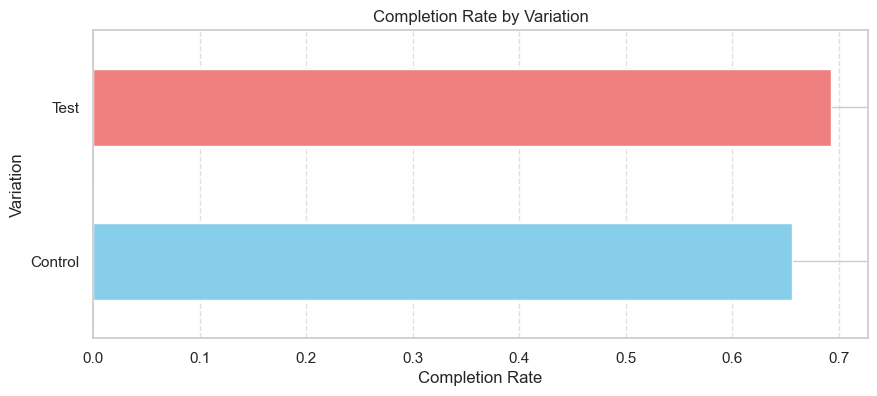

In [21]:
import matplotlib.pyplot as plt

# Plotting Completion Rate as Horizontal Bar Plot with Percentage Labels
plt.figure(figsize=(10, 4))
ax = completion_rate.plot(kind='barh', color=['skyblue', 'lightcoral'])
plt.title('Completion Rate by Variation')
plt.xlabel('Completion Rate')
plt.ylabel('Variation')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()


## Hypothesis Testing

In [ ]:
# By the previous part we know that the variable 'process_step' has no missing values
# We will do it again but only for the Control and Test variations 

# Missing values for 'process_step' variable in Control and Test variations 
print("Missing values in Control variation:")
print(df_merged[df_merged['Variation'] == 'Control']['process_step'].isnull().sum())

print("Missing values in Test variation:")
print(df_merged[df_merged['Variation'] == 'Test']['process_step'].isnull().sum())


In [5]:
# Completion Rate
control_completion_rate = df_merged[df_merged['Variation'] == 'Control']['process_step'].eq('confirm').mean()
test_completion_rate = df_merged[df_merged['Variation'] == 'Test']['process_step'].eq('confirm').mean()

# Standard error of the difference
std_error_diff = ((control_completion_rate * (1 - control_completion_rate)) / len(df_merged[df_merged['Variation'] == 'Control'])) + \
                 ((test_completion_rate * (1 - test_completion_rate)) / len(df_merged[df_merged['Variation'] == 'Test']))
std_error_diff = std_error_diff ** 0.5

# Two-sample proportions z-test
z_stat, p_value = proportions_ztest([control_completion_rate * len(df_merged[df_merged['Variation'] == 'Control']),
                                     test_completion_rate * len(df_merged[df_merged['Variation'] == 'Test'])],
                                    [len(df_merged[df_merged['Variation'] == 'Control']),
                                     len(df_merged[df_merged['Variation'] == 'Test'])])

# Results
print("Completion Rate Hypothesis Testing:")
print(f"Control Completion Rate: {control_completion_rate}")
print(f"Test Completion Rate: {test_completion_rate}")
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")
print("")
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in completion rates.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in completion rates.")


Completion Rate Hypothesis Testing:
Control Completion Rate: 0.12201837420362187
Test Completion Rate: 0.1446299347191687
Z-statistic: -18.67324116863663
P-value: 8.173840595991908e-78

Reject the null hypothesis. There is a significant difference in completion rates.


In [6]:
# Completion Rate with Cost-Effectiveness Threshold Analysis
threshold = 0.05  # 5%
observed_completion_rate_increase = test_completion_rate - control_completion_rate

# One-sample proportions z-test
z_stat_threshold, p_value_threshold = sm.stats.proportions_ztest(observed_completion_rate_increase * len(df_merged),
                                                                 len(df_merged),
                                                                 value=threshold,
                                                                 alternative='larger')

# Results
print("\nCompletion Rate with Cost-Effectiveness Threshold Analysis:")
print(f"Observed Completion Rate Increase: {observed_completion_rate_increase}")
print(f"Z-statistic: {z_stat_threshold}")
print(f"P-value: {p_value_threshold}")
print("")
if p_value_threshold < 0.05:
    print(f"Reject the null hypothesis. The observed increase meets or exceeds the {threshold * 100}% threshold.")
else:
    print(f"Fail to reject the null hypothesis. The observed increase does not meet the {threshold * 100}% threshold.")



Completion Rate with Cost-Effectiveness Threshold Analysis:
Observed Completion Rate Increase: 0.022611560515546844
Z-statistic: -123.56432809551994
P-value: 1.0

Fail to reject the null hypothesis. The observed increase does not meet the 5.0% threshold.


In [10]:
# Missing values for 'clnt_age' variable
print("Missing values in Control variation:")
print(df_merged[df_merged['Variation'] == 'Control']['clnt_age'].isnull().sum())

print("Missing values in Test variation:")
print(df_merged[df_merged['Variation'] == 'Test']['clnt_age'].isnull().sum())


Missing values in Control variation:
54
Missing values in Test variation:
60


In [7]:
# Average Age of Clients and filtering non-NaN values for the Hypothesis Testing
control_age = df_merged[df_merged['Variation'] == 'Control']['clnt_age'].dropna()
test_age = df_merged[df_merged['Variation'] == 'Test']['clnt_age'].dropna()


# Two-sample t-test
t_stat, p_value_age = ttest_ind(control_age, test_age, equal_var=True)

# Results
print("\nAverage Age of Clients Hypothesis Testing:")
print(f"Average Age (Control): {control_age.mean()}")
print(f"Average Age (Test): {test_age.mean()}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value_age}")
print("")
if p_value_age < 0.05:
    print("Reject the null hypothesis. There is a significant difference in average age.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in average age.")



Average Age of Clients Hypothesis Testing:
Average Age (Control): 48.30989554278701
Average Age (Test): 48.75001828030171
T-statistic: -7.926400435419626
P-value: 2.263054043650787e-15

Reject the null hypothesis. There is a significant difference in average age.


In [12]:
from scipy import stats
standard_error = stats.sem(control_age, axis=0, nan_policy='omit')
standard_error

stats.t.interval(0.95,df= len(control_age) - 1,scale = standard_error,loc=control_age.mean())

(48.22903052977982, 48.3907605557942)

C:\Users\user\AppData\Local\Temp\ipykernel_7652\2722961259.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(control_age,label='Control Group')
C:\Users\user\AppData\Local\Temp\ipykernel_7652\2722961259.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_age,label='Test Group')


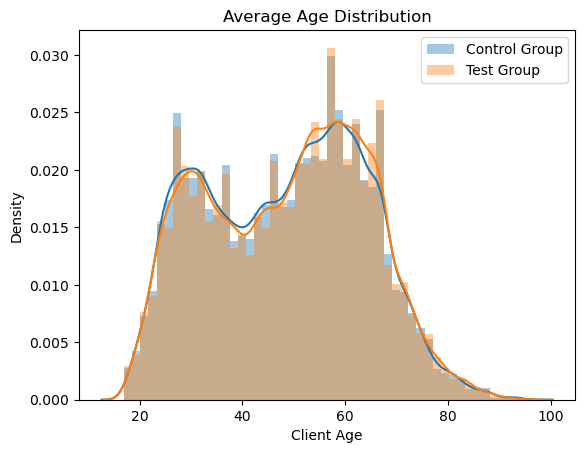

In [17]:
sns.distplot(control_age,label='Control Group')
sns.distplot(test_age,label='Test Group')
plt.title('Average Age Distribution')
plt.xlabel('Client Age')
plt.legend()
plt.show()